## Imports

In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
analysis_params = [{
  "model_type": "ica",
  "model_name": "ica",
  "version": "0.0",
  "weights": "weights/w_analysis:0",
  "save_info": "analysis",
  "overwrite_analysis": False},

  {"model_type": "sparse_autoencoder",
  "model_name": "sparse_autoencoder",
  "version": "0.0",
  "weights": "weights/w_enc:0",
  "save_info": "analysis",
  "overwrite_analysis": False},

  {"model_type": "lca",
  "model_name": "lca_256_l0_2.5",
  "version": "1.0",
  "weights": "weights/phi:0",
  "save_info": "full_imgs",
  "overwrite_analysis": False}]

# Computed params
for params in analysis_params:
  params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+params["model_name"])

In [4]:
class params_obj(object):
  def __init__(self, dictionary):
    for key, val in dictionary.items():
      setattr(self, key, val)
analyzers = []
for params in analysis_params:
  pobj = params_obj(params)
  analyzer = ap.get_analyzer(pobj)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=pobj.save_info)
  analyzers.append(analyzer)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dpaiton/Work/Projects/ica/logfiles/ica_v0.0.log'

In [5]:
neuron_angle_list = []
for analyzer in analyzers:
  num_pixels = analyzer.model_params.num_pixels
  neuron_angles = np.zeros((analyzer.bf_stats["num_outputs"], analyzer.bf_stats["num_outputs"]))
  for neuron1 in range(analyzer.bf_stats["num_outputs"]):
    #for neuron2 in range(0,neuron1):
    #  neuron_angles[neuron1, neuron2] = None
    #for neuron2 in range(neuron1, analyzer.bf_stats["num_outputs"]):
    for neuron2 in range(analyzer.bf_stats["num_outputs"]):
      bf1 = analyzer.bf_stats["basis_functions"][neuron1].reshape((num_pixels,1))
      bf2 = analyzer.bf_stats["basis_functions"][neuron2].reshape((num_pixels,1))
      inner_products = np.dot((bf1/np.linalg.norm(bf1)).T, bf2/np.linalg.norm(bf2))
      inner_products[inner_products>1.0] = 1.0
      inner_products[inner_products<-1.0] = -1.0
      angle = np.arccos(inner_products)
      neuron_angles[neuron1, neuron2] = angle
  neuron_angle_list.append(neuron_angles)

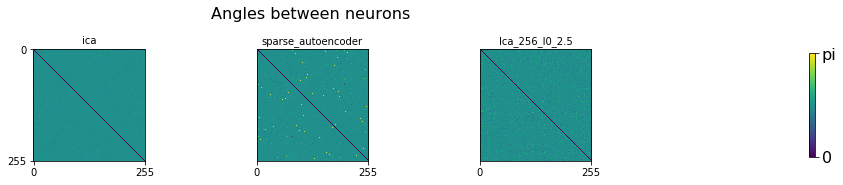

In [6]:
cmap = plt.get_cmap('viridis')
vmin = 0
vmax = np.pi
cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []
fig, ax = plt.subplots(1, len(neuron_angle_list)+1, figsize=(14,14))
fig.subplots_adjust(wspace=1.0)
for idx, neuron_angles in enumerate(neuron_angle_list):
  im = ax[idx].imshow(neuron_angles, clim=[vmin,vmax])
  ax[idx].set_xticks([0, analyzers[0].bf_stats["num_outputs"]-1])
  ax[idx].tick_params("both", labelsize=10)
  ax[idx].get_yaxis().set_visible(False)
  ax[idx].set_title(analyzers[idx].model_name, fontsize=10)
ax[0].set_yticks([0, analyzers[0].bf_stats["num_outputs"]-1])
ax[0].get_yaxis().set_visible(True)
im = ax[-1].imshow(np.zeros_like(neuron_angles), vmin=vmin, vmax=vmax)
ax[-1].set_visible(False)
cbar = pf.add_colorbar_to_im(im, ticks=[vmin, vmax])
cbar.ax.set_yticklabels(["0","pi"])
fig.suptitle("Angles between neurons", y=0.6, x=0.4, fontsize=16)
plt.show()

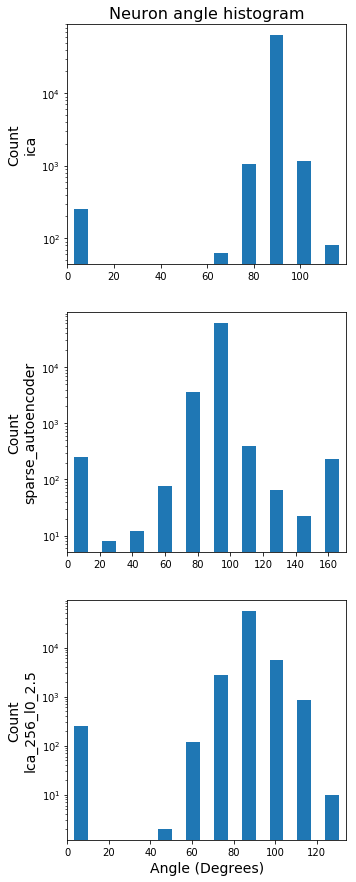

In [7]:
fig, ax = plt.subplots(len(neuron_angle_list), figsize=(5,5*len(neuron_angle_list)))
#fig.subplots_adjust(hspace=0.1)
for idx, neuron_angles in enumerate(neuron_angle_list):
  angles = neuron_angles[np.isfinite(neuron_angles)].flatten()*(180/np.pi)
  xlims = [0, np.max(angles)]
  ax[idx].hist(angles, rwidth=0.5, log=True)
  ax[idx].set_xlim(xlims)
  ax[idx].set_ylabel("Count\n"+analyzers[idx].model_name, fontsize=14)
ax[0].set_title("Neuron angle histogram", fontsize=16)
ax[-1].set_xlabel("Angle (Degrees)", fontsize=14)
plt.show()

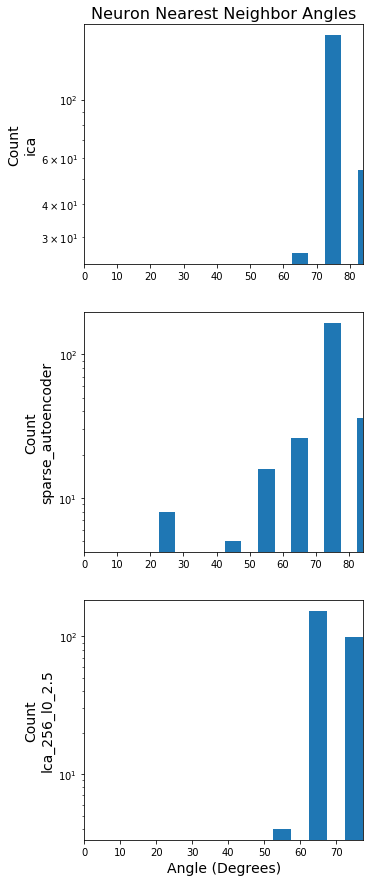

In [8]:
fig, ax = plt.subplots(len(analyzers), figsize=(5, 5*len(analyzers)))
for idx, analyzer in enumerate(analyzers):
  nn_angles = np.zeros(analyzer.bf_stats["num_outputs"])
  for neuron_id in range(analyzer.bf_stats["num_outputs"]): 
    neighbors = neuron_angle_list[idx][neuron_id,:] * (180/np.pi)
    nn_angles[neuron_id] = np.min(np.delete(neighbors, neuron_id))
  ax[idx].hist(nn_angles.flatten(), rwidth=0.5, bins=np.linspace(0,90,10), log=True)
  ax[idx].set_xlim([0, np.max(nn_angles)])
  ax[idx].set_ylabel("Count\n"+analyzer.model_name, fontsize=14)
ax[0].set_title("Neuron Nearest Neighbor Angles", fontsize=16)
ax[-1].set_xlabel("Angle (Degrees)", fontsize=14)
plt.show()

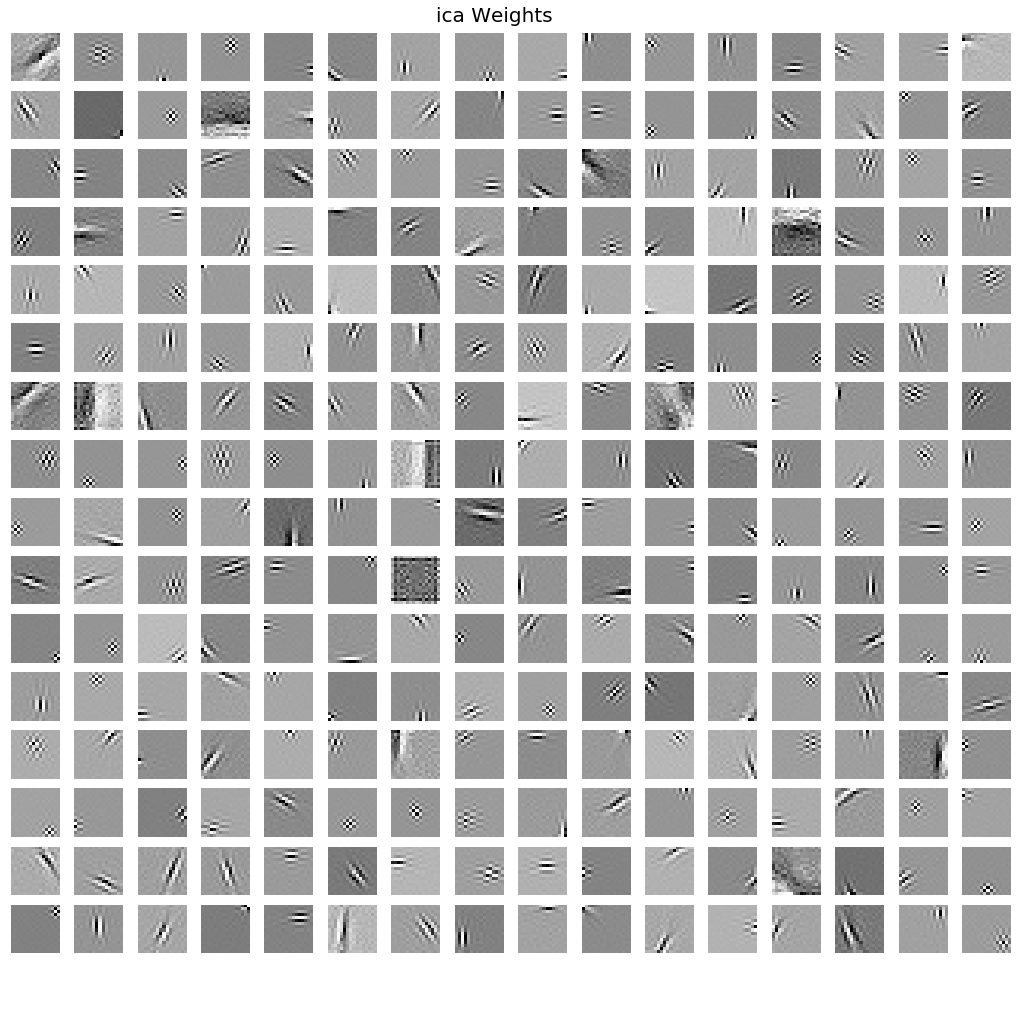

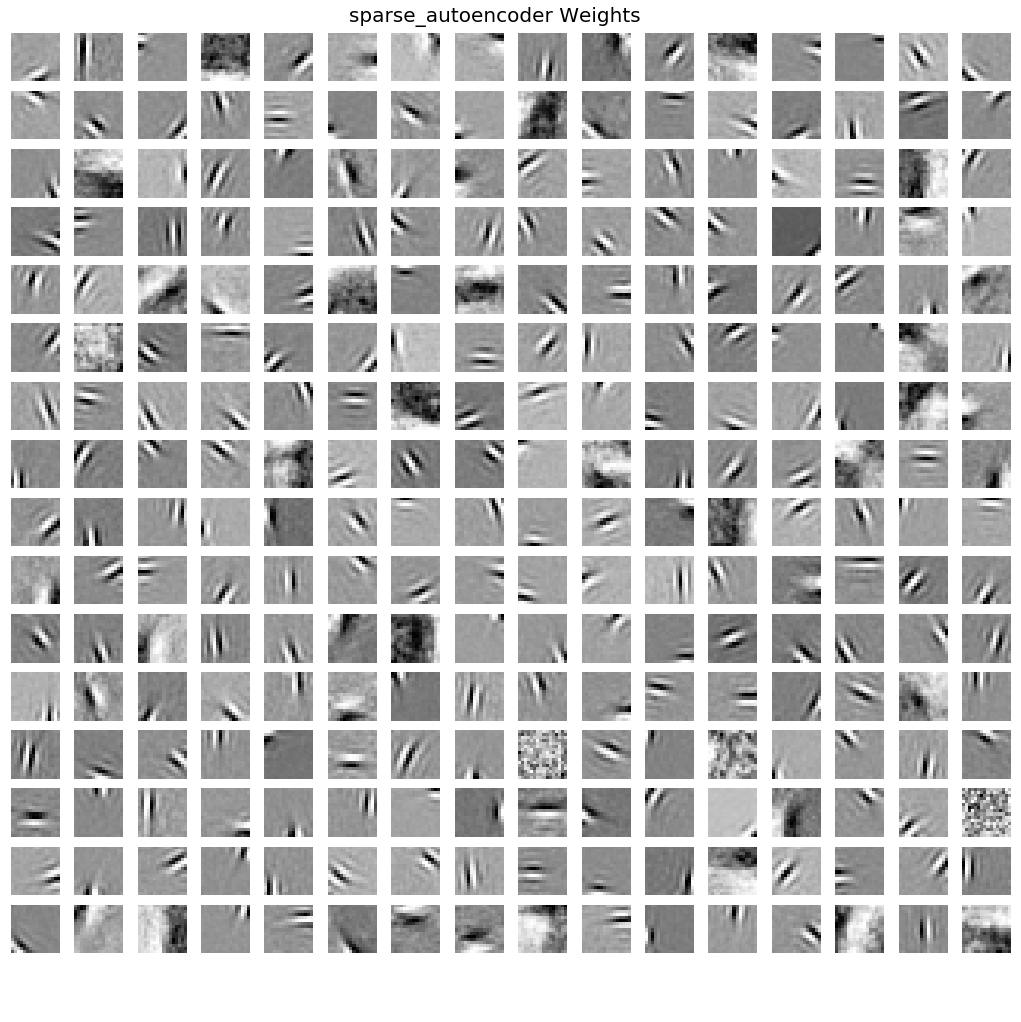

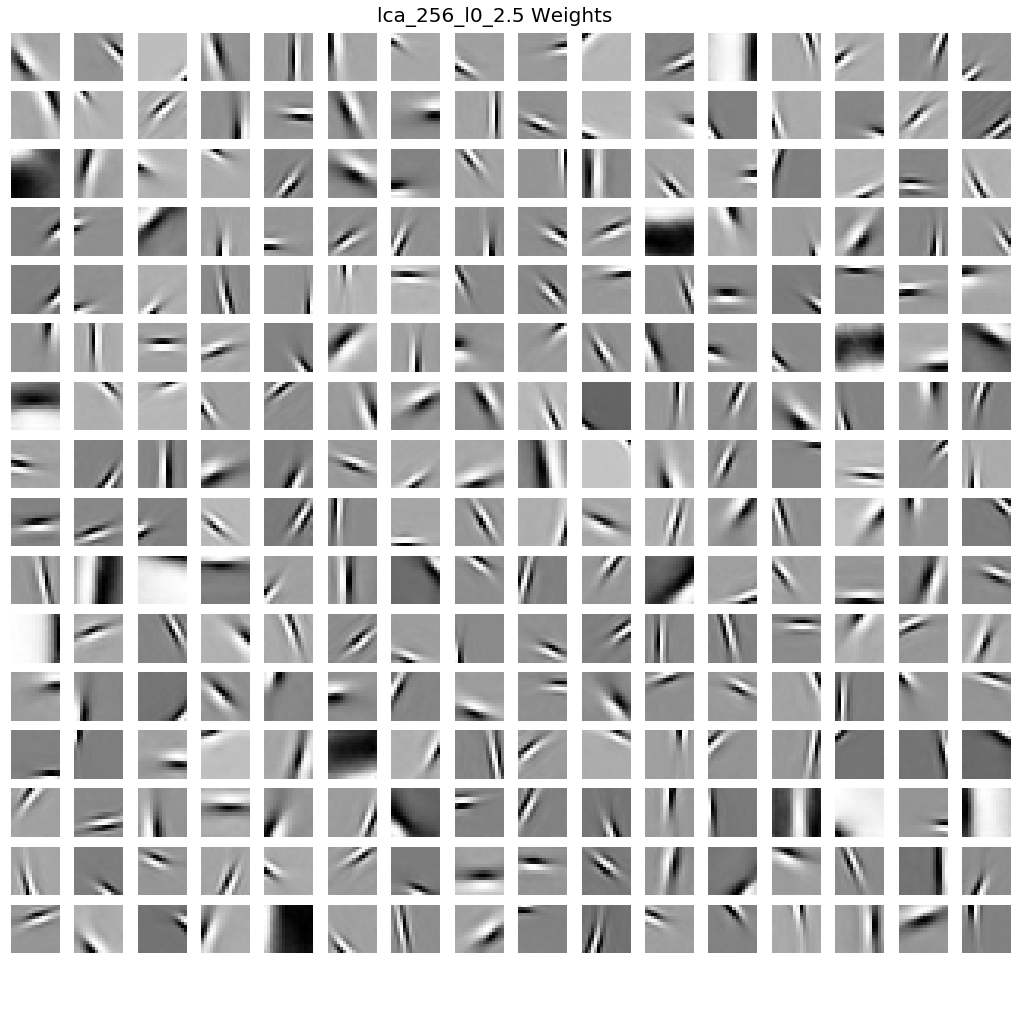

In [10]:
for idx, analyzer in enumerate(analyzers):
  weight_name = analysis_params[idx]["weights"]
  weight_shape = [analyzer.bf_stats["num_outputs"], analyzer.bf_stats["patch_edge_size"],
    analyzer.bf_stats["patch_edge_size"]]
  dict_fig = pf.plot_weights(analyzer.evals[weight_name].T.reshape(weight_shape),
    title=analyzer.model_name+" Weights")

In [13]:
def plot_loc_freq_summaries(analyzer_list, spot_size=13, spot_alpha=0.5):
  max_sfs = []
  max_envelopes = []
  fig, sub_ax = plt.subplots(1, 3, figsize=(15,5))
  for analyzer in analyzer_list:
    bf_stats = analyzer.bf_stats
    x_pos = [x for (y,x) in bf_stats["gauss_centers"]]
    y_pos = [y for (y,x) in bf_stats["gauss_centers"]]
    sub_ax[0].scatter(x_pos, y_pos, s=spot_size, alpha=spot_alpha, label=analyzer.model_name)
    sub_ax[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    sub_ax[0].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    x_sf = [x for (y,x) in bf_stats["fourier_centers"]]
    y_sf = [y for (y,x) in bf_stats["fourier_centers"]]
    max_sfs.append(np.max(np.abs(x_sf+y_sf)))
    sub_ax[1].scatter(x_sf, y_sf, s=spot_size, alpha=spot_alpha, label=analyzer.model_name)
    sub_ax[1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    sub_ax[1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    widths = [width for ((width, height), _) in bf_stats["gauss_orientations"]]
    heights = [height for ((width, height), _) in bf_stats["gauss_orientations"]]
    max_envelopes.append(np.max([widths, heights]))
    sub_ax[2].scatter(widths, heights, s=spot_size, alpha=spot_alpha, label=analyzer.model_name)
  patch_edge_size = analyzers[0].bf_stats["patch_edge_size"]
  sub_ax[0].set_xlim([0, patch_edge_size-1])
  sub_ax[0].set_ylim([patch_edge_size-1, 0])
  sub_ax[0].set_aspect("equal")
  sub_ax[0].set_ylabel("Pixels")
  sub_ax[0].set_xlabel("Pixels")
  sub_ax[0].set_title("Basis Function Centers", fontsize=12)
  sub_ax[1].set_aspect("equal")
  sub_ax[1].set_ylabel("Cycles / Patch")
  sub_ax[1].set_xlabel("Cycles / Patch")
  sub_ax[1].set_title("Basis Function Spatial Frequencies", fontsize=12)
  sub_ax[1].set_xlim([-np.max(max_sfs), np.max(max_sfs)])
  sub_ax[1].set_ylim([-np.max(max_sfs), np.max(max_sfs)])
  sub_ax[2].set_aspect("equal")
  sub_ax[2].set_ylabel("Envelope Length")
  sub_ax[2].set_xlabel("Envelope Width")
  sub_ax[2].set_title("Basis Function Spatial Receptive Field", fontsize=12)
  sub_ax[2].set_xlim([0, patch_edge_size])
  sub_ax[2].set_ylim([0, patch_edge_size])
  sub_ax[2].legend()
  plt.show()
  return fig

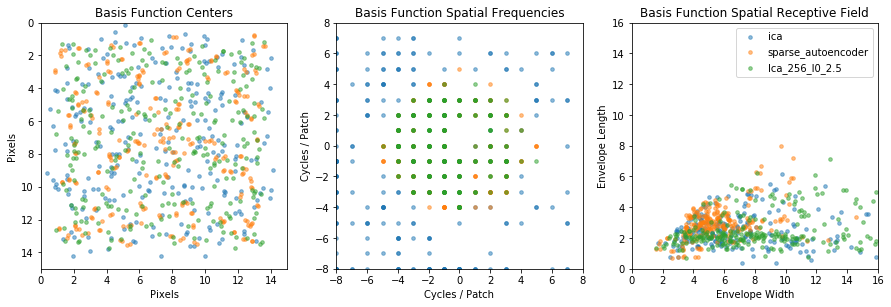

In [14]:
fig = plot_loc_freq_summaries(analyzers)
fig.savefig("/home/dpaiton/fig_location_frequency_centers.png")

In [15]:
file_loc = "/home/dpaiton/Work/DeepSparseCoding/data_batches.npz"
#data_batches = []
#for analyzer in analyzers:
#  data = ds.get_data(analyzer.model_params)
#  data = analyzer.model.preprocess_dataset(data)
#  data = analyzer.model.reshape_dataset(data, analyzer.model_params)
#  analyzer.model_params.data_shape = [data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     
#  data_batches.append(data["train"].next_batch(1000)[0])
#np.savez(file_loc, data=data_batches)
data_batches = np.load(file_loc)["data"].item()

ValueError: can only convert an array of size 1 to a Python scalar

In [14]:
#data["train"].w_filter
inv_w_filter = np.where(data["train"].w_filter == 0, np.zeros_like(data["train"].w_filter), 1/data["train"].w_filter)

/home/dpaiton/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


### Denoising
* It is unclear whether we should be whitening the stimulus
  * LCA assumes a standard normal noise model, so it denoises best when the noise is white
  * This means that we would want to add white noise to the whitened images. If we add white noise to the images then whiten, we will be coloring the white noise
  * If we add noise to the whitened images, how would we compare to other models?

In [1]:
var_names = ["output/image_estimate/reconstruction:0"]
noise_std = 0.01
noise_mean = 0.0
mse_list = []
for data_batch, analyzer in zip(data_batches, analyzers):
  noisy_data_batch = data_batch + analyzer.rand_state.normal(noise_mean, noise_std, data_batch.shape)
  recons = analyzer.evaluate_model(noisy_data_batch, var_names)[var_names[0]]
  mse_list.append(dp.compute_mse(data_batch, recons))

NameError: name 'data_batches' is not defined